In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

from nanonets import Simulation

plt.style.use(["science","bright","grid"])

# PARAMETERS
V_INPUT_MAX = 0.1
V_GATE_MAX  = 0.1
N_INPUTS    = 320
N_GATES     = 320
V_INPUT     = np.round(np.linspace(-V_INPUT_MAX, V_INPUT_MAX, N_INPUTS),4)
V_I_PLOT    = 1000*V_INPUT
V_GATES     = np.round(np.linspace(-V_GATE_MAX, V_GATE_MAX, N_INPUTS),4)
V_G_PLOT    = 1000*V_GATES
PATH        = "/home/jonasmensing/bagheera/data/1_funding_period/iv_curves/set/"

# TIME
AC_TIME     = 40e-9
BATCH_TIME  = 20*AC_TIME

# Cap Matrix
topo    = {"Nx": 1,"Ny": 1, "electrode_type": ['constant','constant']}
sim_c   = Simulation(topo)
ele_c   = sim_c.ELE_CHARGE_A_C
cap_m   = sim_c.get_capacitance_matrix()
cap_t   = cap_m[0][0]
cap_g   = sim_c.self_capacitance_sphere(3.9,10.0)
cap_m   = sim_c.mutual_capacitance_adjacent_spheres(2.6,10.0,10.0,1.0)
def s_i_th(Ug, n):
    return ((n+0.5)*ele_c + cap_g*Ug)/(cap_t-cap_m)
def i_d_th(Ug, n):
    return ((0.5-n)*ele_c - cap_g*Ug)/(cap_m)

### IV Curve

In [2]:
iv_wo_gate_data = pd.read_csv("data/set.csv")
iv_wo_gate_pot  = pd.read_csv("data/mean_state_set.csv")
iv_wo_gate_net  = pd.read_csv("data/net_currents_set.csv")

x   = iv_wo_gate_data['E0'].values
y   = iv_wo_gate_data['Observable'].values
y_e = iv_wo_gate_data['Error'].values
p   = iv_wo_gate_pot.iloc[:,2].values
k_t = iv_wo_gate_net.sum(axis=1).values/ele_c
t_f = 1 / k_t
l_t = t_f > BATCH_TIME

# Set Currents via mask to Zero
y[l_t]   = 0.0
y_e[l_t] = 0.0

/tmp/ipykernel_29236/1777048930.py:10: RuntimeWarning: divide by zero encountered in divide
  t_f = 1 / k_t


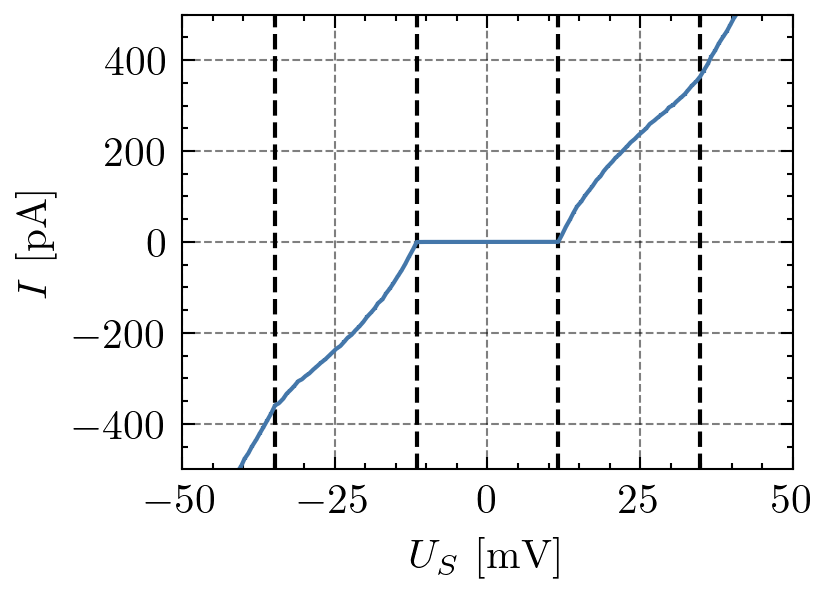

In [3]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i in range(-2,2):
    _ = plt.axvline(s_i_th(0,i)*1000, color='black', ls='--')
_   = ax.errorbar(x*1000, y*1e-6, y_e*1e-6)
_   = ax.set_xlabel("$U_S~[\mathrm{mV}]$")
_   = ax.set_ylabel("$I~[\mathrm{pA}]$")
_   = ax.set_xlim(-50,50)
_   = ax.set_ylim(-500,500)

fig.savefig("plots/svg/set_I_V_wo_G.svg", transparent=True)
fig.savefig("plots/pdf/set_I_V_wo_G.pdf", transparent=False)
fig.savefig("plots/png/set_I_V_wo_G.png", transparent=False)

### Diamonds

In [4]:
y   = {}
y_e = {}
for Vg in V_GATES:
    data = pd.read_csv(f"{PATH}set_{Vg:.5f}.csv")
    net  = pd.read_csv(f"{PATH}net_currents_set_{Vg:.5f}.csv")
    y_v  = data['Observable'].values
    ye_v = data['Error'].values

    k_t  = net.sum(axis=1).values/ele_c
    with np.errstate(divide='ignore'):
        t_f  = 1 / k_t
    l_t  = t_f > BATCH_TIME
    y_v[l_t]    = 0.0
    ye_v[l_t]   = 0.0

    y[Vg] = y_v
    y_e[Vg] = ye_v

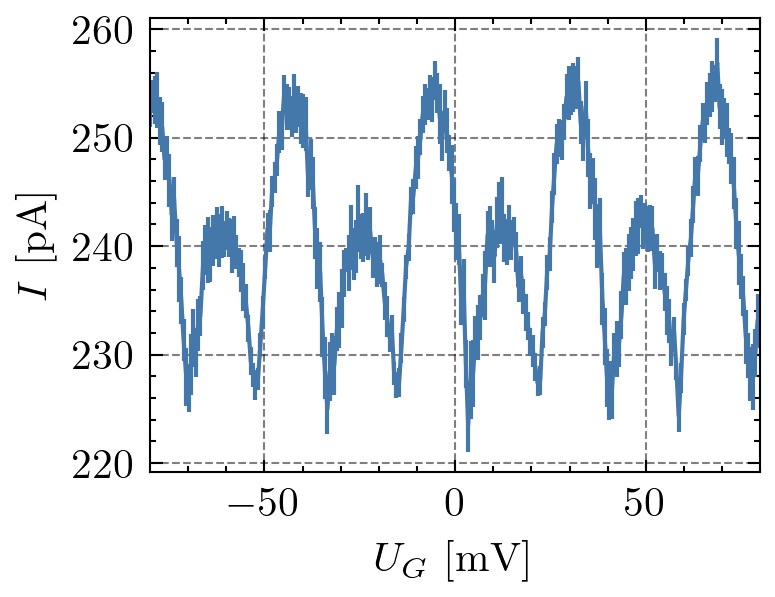

In [18]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
idx     = 200
fig.set_size_inches(w * scale, h * scale)
_   = ax.errorbar(x*1000, [y[Vg][idx]*1e-6 for Vg in V_GATES], [y_e[Vg][idx]*1e-6 for Vg in V_GATES])
_   = ax.set_xlabel("$U_G~[\mathrm{mV}]$")
_   = ax.set_ylabel("$I~[\mathrm{pA}]$")
_   = ax.set_xlim(-80,80)
# _   = ax.set_xlim(-50,50)
# _   = ax.set_ylim(-500,500)

fig.savefig("plots/svg/set_I_Vg_curve.svg", transparent=True)
fig.savefig("plots/pdf/set_I_Vg_curve.pdf", transparent=False)
fig.savefig("plots/png/set_I_Vg_curve.png", transparent=False)

In [ ]:
g     = {Vg : np.gradient(y[Vg],V_INPUT) for Vg in V_GATES}
y_arr = np.array([g[Vg] for Vg in V_GATES])

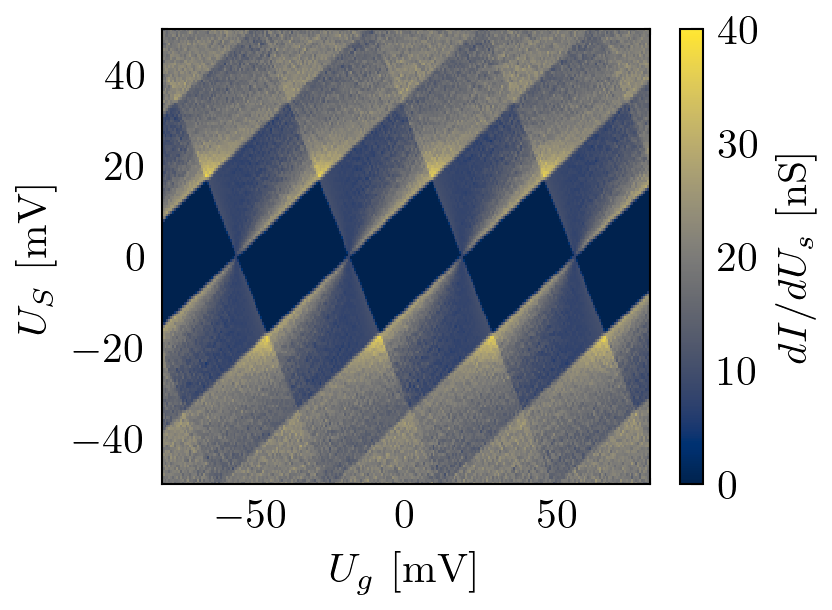

In [ ]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
pcm = ax.pcolormesh(V_GATES*1000, V_INPUT*1000, y_arr.T*1e-9, cmap='cividis', vmin=0, vmax=40)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("$dI/dU_s~[\mathrm{nS}]$")

ax.set_xlim(-80,80)
ax.set_ylim(-50,50)
_ = ax.set_xlabel("$U_g~[\mathrm{mV}]$")
_ = ax.set_ylabel("$U_S~[\mathrm{mV}]$")
fig.savefig("plots/svg/set_diamonds.svg", transparent=True)
fig.savefig("plots/pdf/set_diamonds.pdf", transparent=False)
fig.savefig("plots/png/set_diamonds.png", transparent=False)

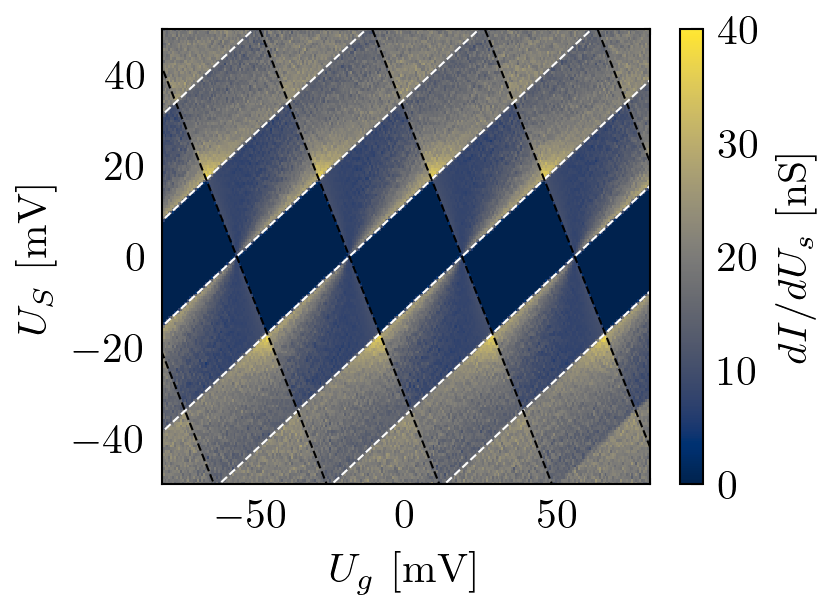

In [131]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
pcm = ax.pcolormesh(V_GATES*1000, V_INPUT*1000, y_arr.T*1e-9, cmap='cividis', vmin=0, vmax=40)
for n in [-3,-2,-1,0,1,2,3]:
    ax.plot(V_GATES*1000,1000*s_i_th(V_GATES,n), color='white', ls='--', lw=0.5)
    ax.plot(V_GATES*1000,1000*i_d_th(V_GATES,n), color='black', ls='--', lw=0.5)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("$dI/dU_s~[\mathrm{nS}]$")
ax.set_xlim(-80,80)
ax.set_ylim(-50,50)
_ = ax.set_xlabel("$U_g~[\mathrm{mV}]$")
_ = ax.set_ylabel("$U_S~[\mathrm{mV}]$")
fig.savefig("plots/svg/set_diamonds_plus_theory.svg", transparent=True)
fig.savefig("plots/pdf/set_diamonds_plus_theory.pdf", transparent=False)
fig.savefig("plots/png/set_diamonds_plus_theory.png", transparent=False)